In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, TemporalData
from sklearn.preprocessing import MinMaxScaler
import optuna
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/home/abijaksana/Universitas Hasanuddin/Semester IV/Data Mining/prediksi_harga_pangan/env/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Membaca dataset
df = pd.read_csv("harga_beras_premium.csv")
print(df.head(5))
print(df.shape)

      Tanggal      Komoditas             Provinsi    Harga
0  17/05/2022  Beras Premium  Nusa Tenggara Barat  10667.0
1  17/05/2022  Beras Premium     Sulawesi Selatan  10918.0
2  17/05/2022  Beras Premium             Bengkulu  11475.0
3  17/05/2022  Beras Premium               Banten  11163.0
4  17/05/2022  Beras Premium       D.I Yogyakarta  11240.0
(41648, 4)


In [4]:
# Mengecek missing values dari dataframe
null_values = df.isnull().sum()
null_values

Tanggal         0
Komoditas       0
Provinsi        0
Harga        4294
dtype: int64

In [5]:
# Menghapus missing value dari dataframe
df_cleaned = df.dropna()
print(df_cleaned.isnull().sum())
print(df_cleaned.shape)

Tanggal      0
Komoditas    0
Provinsi     0
Harga        0
dtype: int64
(37354, 4)


In [6]:
# Konversi kolom Tanggal ke datetime
df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
df_cleaned.head(5)

/tmp/ipykernel_18980/1040587474.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
/tmp/ipykernel_18980/1040587474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])


,Tanggal,Komoditas,Provinsi,Harga
0,2022-05-17,Beras Premium,Nusa Tenggara Barat,10667.0
1,2022-05-17,Beras Premium,Sulawesi Selatan,10918.0
2,2022-05-17,Beras Premium,Bengkulu,11475.0
3,2022-05-17,Beras Premium,Banten,11163.0
4,2022-05-17,Beras Premium,D.I Yogyakarta,11240.0


In [7]:
df_cleaned = df_cleaned.sort_values(['Tanggal', 'Provinsi'])

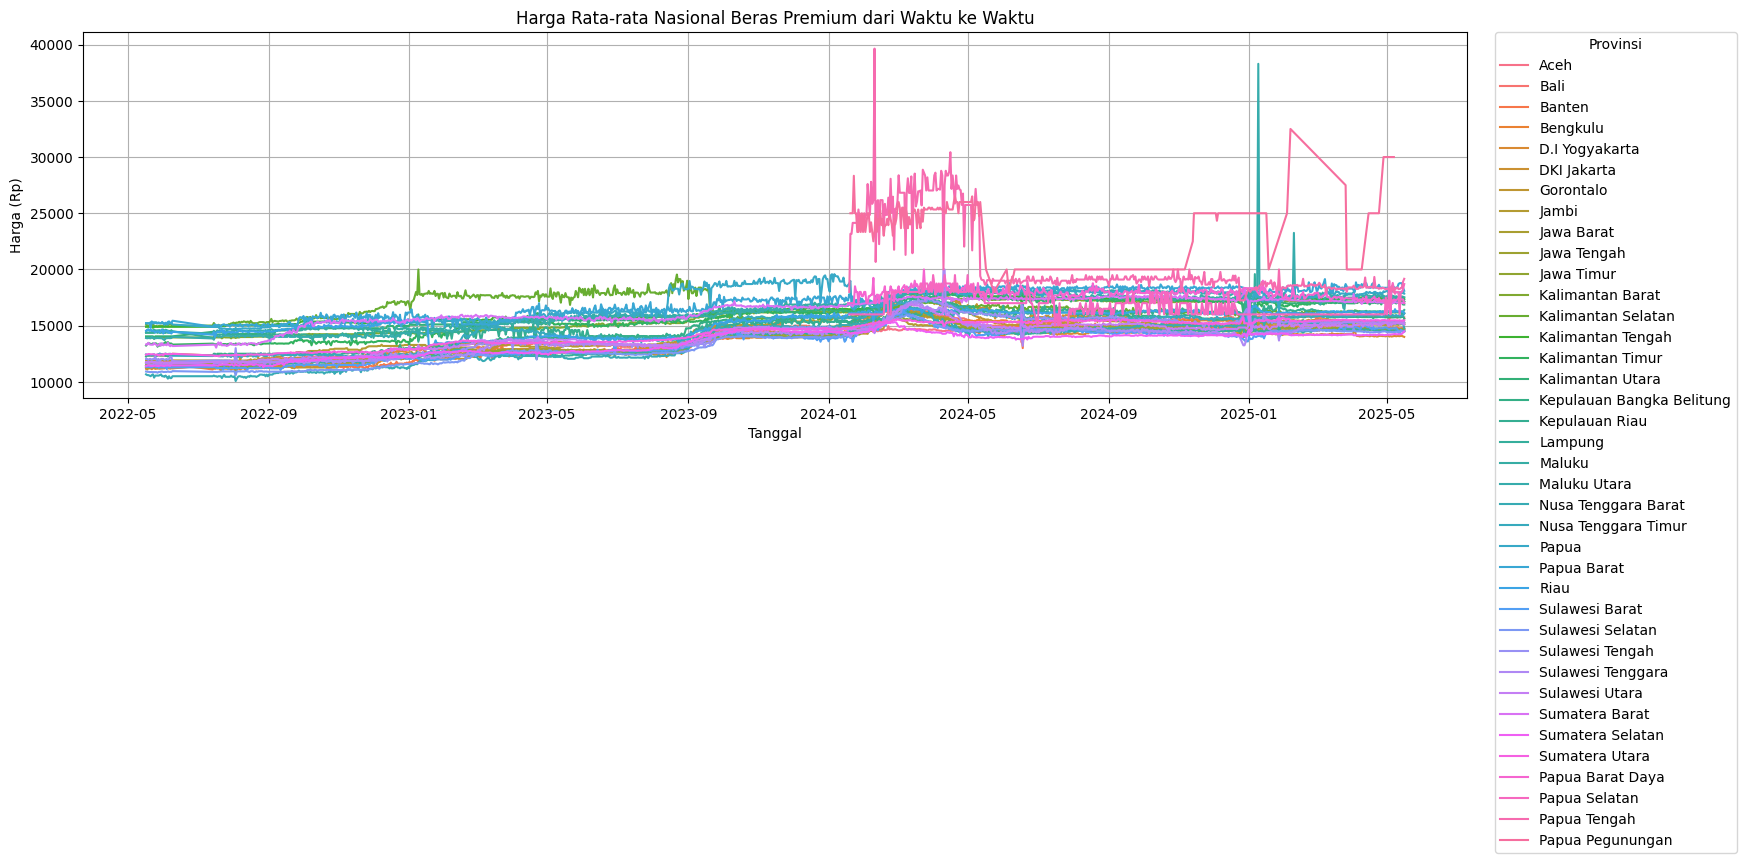

In [8]:
plt.figure(figsize=(20, 7))
sns.lineplot(x='Tanggal', y='Harga', data=df_cleaned, hue='Provinsi')
plt.title('Harga Rata-rata Nasional Beras Premium dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.grid(True)
# Letakkan legenda di luar plot
plt.legend(title='Provinsi', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
# Sesuaikan layout agar legenda tidak terpotong
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()  # changed

In [9]:
# Pivot Data
df_pivot = df_cleaned.pivot(index='Tanggal', columns='Provinsi', values='Harga')
df_pivot.head(5)

Provinsi,Aceh,Bali,Banten,Bengkulu,D.I Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua Tengah,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Tanggal,,,,,,,,,,,,,,,,,,,,,
2022-05-17,11762.0,11396.0,11163.0,11475.0,11240.0,12333.0,11258.0,11909.0,11558.0,11456.0,...,NaN,14548.0,11333.0,10918.0,12036.0,11653.0,11762.0,13320.0,11406.0,12416.0
2022-05-18,11703.0,11407.0,11186.0,11475.0,11240.0,12333.0,11092.0,11909.0,11559.0,11431.0,...,NaN,14586.0,11333.0,10895.0,12036.0,11740.0,11762.0,13317.0,11441.0,12448.0
2022-05-19,11762.0,11407.0,11286.0,11475.0,11200.0,12333.0,11250.0,11909.0,11559.0,11384.0,...,NaN,14685.0,11333.0,10895.0,11950.0,11575.0,11762.0,13472.0,11469.0,12474.0
2022-05-20,11811.0,11407.0,11225.0,11475.0,11200.0,12333.0,11258.0,11909.0,11561.0,11431.0,...,NaN,14537.0,11333.0,10873.0,12036.0,11573.0,11754.0,13332.0,11441.0,12471.0
2022-05-21,11752.0,11407.0,11225.0,11475.0,11200.0,12333.0,11275.0,11909.0,11580.0,11368.0,...,NaN,14667.0,11283.0,10873.0,12040.0,11544.0,11792.0,13312.0,11406.0,12447.0


In [10]:
# Pastikan tanggal terurut naik
df_pivot = df_pivot.sort_index()

# 1. Interpolasi linear untuk lubang di antara dua titik valid
df_interp = df_pivot.interpolate(method='linear', limit_direction='both')

# 2. Isi sisa missing di ujung (awal/akhir) dengan forward/backward fill
df_cleaned_ts = (
    df_interp
    .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
    .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya
)

/tmp/ipykernel_18980/1131224560.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
/tmp/ipykernel_18980/1131224560.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya


In [11]:
# Ambil data provinsi
provinsi_list = sorted(df_cleaned_ts.columns.tolist())

# Mengubah data tiap provinsi menjadi index
provinsi_to_index = {prov: idx for idx, prov in enumerate(provinsi_list)}

print(provinsi_list)
print(provinsi_to_index)

['Aceh', 'Bali', 'Banten', 'Bengkulu', 'D.I Yogyakarta', 'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Papua Barat Daya', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']
{'Aceh': 0, 'Bali': 1, 'Banten': 2, 'Bengkulu': 3, 'D.I Yogyakarta': 4, 'DKI Jakarta': 5, 'Gorontalo': 6, 'Jambi': 7, 'Jawa Barat': 8, 'Jawa Tengah': 9, 'Jawa Timur': 10, 'Kalimantan Barat': 11, 'Kalimantan Selatan': 12, 'Kalimantan Tengah': 13, 'Kalimantan Timur': 14, 'Kalimantan Utara': 15, 'Kepulauan Bangka Belitung': 16, 'Kepulauan Riau': 17, 'Lampung': 18, 'Maluku':

In [12]:
edges = [
    # Sumatera
    ('Aceh', 'Sumatera Utara'),  # Aceh berbatasan langsung dengan Sumut
    ('Sumatera Utara', 'Sumatera Barat'),  # Sumut berbatasan dengan Sumbar
    ('Sumatera Utara', 'Riau'),  # Sumut berbatasan dengan Riau
    ('Sumatera Barat', 'Riau'),  # Sumbar berbatasan dengan Riau
    ('Riau', 'Kepulauan Riau'),  # Riau terhubung via laut ke Kepri
    ('Riau', 'Jambi'),  # Riau berbatasan dengan Jambi
    ('Jambi', 'Sumatera Selatan'),  # Jambi berbatasan dengan Sumsel
    ('Sumatera Selatan', 'Bengkulu'),  # Sumsel berbatasan dengan Bengkulu
    ('Sumatera Selatan', 'Lampung'),  # Sumsel berbatasan dengan Lampung
    ('Bengkulu', 'Lampung'),  # Bengkulu berbatasan dengan Lampung
    ('Sumatera Selatan', 'Kepulauan Bangka Belitung'),  # Sumsel terhubung via laut ke Babel

    # Jawa
    ('Banten', 'DKI Jakarta'),  # Banten berbatasan dengan DKI
    ('Banten', 'Jawa Barat'),  # Banten berbatasan dengan Jabar
    ('DKI Jakarta', 'Jawa Barat'),  # DKI berbatasan dengan Jabar
    ('Jawa Barat', 'Jawa Tengah'),  # Jabar berbatasan dengan Jateng
    ('Jawa Tengah', 'D.I Yogyakarta'),  # Jateng mengelilingi DIY
    ('Jawa Tengah', 'Jawa Timur'),  # Jateng berbatasan dengan Jatim
    ('Jawa Timur', 'D.I Yogyakarta'),  # Relasi ekonomi/transportasi (tidak langsung berbatasan darat, opsional)

    # Bali dan Nusa Tenggara
    ('Bali', 'Nusa Tenggara Barat'),  # Bali terhubung ferry ke NTB
    ('Nusa Tenggara Barat', 'Nusa Tenggara Timur'),  # NTB berbatasan laut dengan NTT

    # Kalimantan
    ('Kalimantan Barat', 'Kalimantan Tengah'),  # Kalbar berbatasan dengan Kalteng
    ('Kalimantan Barat', 'Kalimantan Utara'),  # Kalbar berbatasan dengan Kalut (via perbatasan utara)
    ('Kalimantan Tengah', 'Kalimantan Selatan'),  # Kalteng berbatasan dengan Kalsel
    ('Kalimantan Tengah', 'Kalimantan Timur'),  # Kalteng berbatasan dengan Kaltim
    ('Kalimantan Selatan', 'Kalimantan Timur'),  # Kalsel berbatasan dengan Kaltim
    ('Kalimantan Timur', 'Kalimantan Utara'),  # Kaltim berbatasan dengan Kalut

    # Sulawesi
    ('Sulawesi Utara', 'Gorontalo'),  # Sulut berbatasan dengan Gorontalo
    ('Gorontalo', 'Sulawesi Tengah'),  # Gorontalo berbatasan dengan Sulteng
    ('Sulawesi Tengah', 'Sulawesi Barat'),  # Sulteng berbatasan dengan Sulbar
    ('Sulawesi Barat', 'Sulawesi Selatan'),  # Sulbar berbatasan dengan Sulsel
    ('Sulawesi Selatan', 'Sulawesi Tenggara'),  # Sulsel berbatasan dengan Sultra
    ('Sulawesi Tengah', 'Sulawesi Selatan'),  # Sulteng berbatasan dengan Sulsel
    ('Sulawesi Tenggara', 'Sulawesi Tengah'),  # Sultra berbatasan dengan Sulteng

    # Maluku dan Papua
    ('Maluku', 'Maluku Utara'),  # Maluku berbatasan laut dengan Malut
    ('Maluku', 'Papua Barat'),  # Maluku berbatasan laut dengan Papua Barat
    ('Maluku', 'Sulawesi Tenggara'),  # Maluku berbatasan laut dengan Sultra
    ('Papua Barat', 'Papua'),  # Papua Barat berbatasan dengan Papua
    ('Papua', 'Papua Pegunungan'),  # Papua berbatasan dengan Papua Pegunungan
    ('Papua Pegunungan', 'Papua Tengah'),  # Papua Pegunungan berbatasan dengan Papua Tengah
    ('Papua Tengah', 'Papua Selatan'),  # Papua Tengah berbatasan dengan Papua Selatan
    ('Papua Barat', 'Papua Barat Daya'),  # Papua Barat berbatasan dengan Papua Barat Daya
    ('Papua Barat Daya', 'Papua'),  # Papua Barat Daya berbatasan dengan Papua
    ('Papua Tengah', 'Papua'),  # Papua Tengah berbatasan dengan Papua
    ('Papua Selatan', 'Papua'),  # Papua Selatan berbatasan dengan Papua
]


In [13]:
# List kosong untuk menampung index
edge_index = []

# Untuk setiap data dari edges akan dikonversi menjadi index yang ada di dictionary provinsi_to_index
for src, dst in edges:
    i, j = provinsi_to_index[src], provinsi_to_index[dst]
    edge_index.append((i, j))
    edge_index.append((j, i))  # graf tidak berarah

import torch
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()


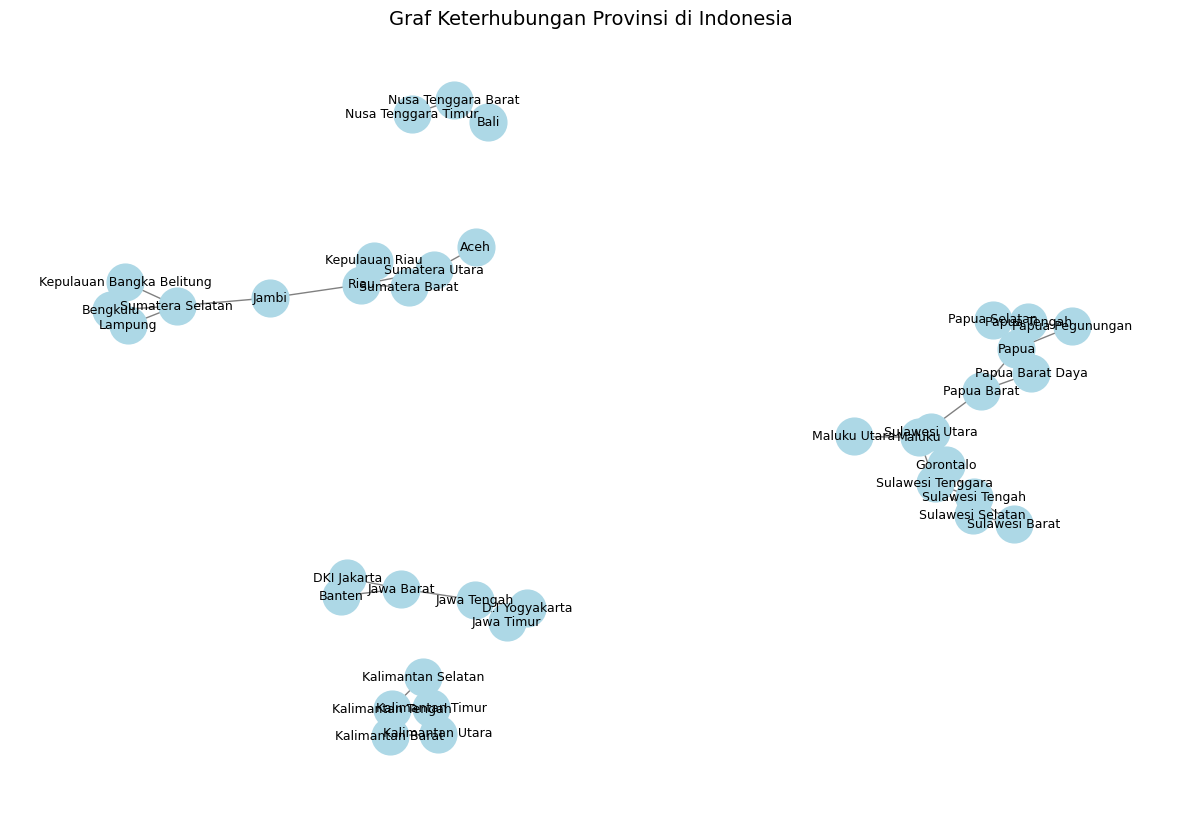

In [14]:
import networkx as nx
# Buat graf kosong
G = nx.Graph()

# Tambahkan node
G.add_nodes_from(provinsi_to_index.keys())

# Tambahkan edge
G.add_edges_from(edges)

# Layout graf (gunakan spring layout agar terlihat rapi)
pos = nx.spring_layout(G, seed=42)  # bisa juga pakai nx.kamada_kawai_layout(G)

# Plot graf
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

plt.title("Graf Keterhubungan Provinsi di Indonesia", fontsize=14)
plt.axis('off')
plt.show()

In [15]:
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(df_cleaned_ts) - 30):  # 30 hari prediksi ke depan
    X.append(df_cleaned_ts.iloc[i-sequence_length:i].values.T)  # shape: (num_provinsi, 30)
    y.append(df_cleaned_ts.iloc[i:i+30].values.T)  # target: 30 hari ke depan

X = np.stack(X)  # shape: (samples, num_provinsi, 30)
y = np.stack(y)  # shape: (samples, num_provinsi, 30)
print(X)
print(y)


[[[11762. 11703. 11762. ... 11780. 11777. 11764.]
  [11396. 11407. 11407. ... 11313. 11214. 11389.]
  [11163. 11186. 11286. ... 11333. 11286. 11313.]
  ...
  [13320. 13317. 13472. ... 13043. 13350. 13513.]
  [11406. 11441. 11469. ... 11471. 11441. 11438.]
  [12416. 12448. 12474. ... 12329. 12309. 12271.]]

 [[11703. 11762. 11811. ... 11777. 11764. 11744.]
  [11407. 11407. 11407. ... 11214. 11389. 11389.]
  [11186. 11286. 11225. ... 11286. 11313. 11313.]
  ...
  [13317. 13472. 13332. ... 13350. 13513. 13307.]
  [11441. 11469. 11441. ... 11441. 11438. 11529.]
  [12448. 12474. 12471. ... 12309. 12271. 12303.]]

 [[11762. 11811. 11752. ... 11764. 11744. 11793.]
  [11407. 11407. 11407. ... 11389. 11389. 11389.]
  [11286. 11225. 11225. ... 11313. 11313. 11313.]
  ...
  [13472. 13332. 13312. ... 13513. 13307. 13493.]
  [11469. 11441. 11406. ... 11438. 11529. 11500.]
  [12474. 12471. 12447. ... 12271. 12303. 12366.]]

 ...

 [[14627. 14611. 14637. ... 14587. 14715. 14689.]
  [15846. 15833. 158

In [16]:
# Normalisasi per provinsi (fitur per node)
scalers = []
X_scaled = np.zeros_like(X)
y_scaled = np.zeros_like(y)
for i in range(X.shape[1]):  # per provinsi
    scaler = MinMaxScaler()
    X_scaled[:, i, :] = scaler.fit_transform(X[:, i, :])
    y_scaled[:, i, :] = scaler.transform(y[:, i, :])
    scalers.append(scaler)
X = X_scaled
y = y_scaled

In [17]:
gnn_dataset = []

for i in range(len(X)):
    x = torch.tensor(X[i], dtype=torch.float)  # node features: (num_nodes, 30)
    y_target = torch.tensor(y[i], dtype=torch.float)  # label
    data = Data(x=x, edge_index=edge_index, y=y_target)
    gnn_dataset.append(data)

## Membuat Dataset Temporal untuk Temporal GNN

Kita akan membentuk dataset temporal, di mana setiap snapshot merepresentasikan satu hari, dan labelnya adalah harga 30 hari ke depan.

In [18]:
from torch_geometric.data import TemporalData

temporal_dataset = []
for i in range(sequence_length, len(df_cleaned_ts) - 30):
    # Fitur node: harga 30 hari terakhir (untuk semua provinsi)
    x = torch.tensor(df_cleaned_ts.iloc[i-sequence_length:i].values.T, dtype=torch.float)  # (num_nodes, 30)
    # Edge index tetap sama untuk semua snapshot
    edge_idx = edge_index
    # Target: harga 30 hari ke depan (untuk semua provinsi)
    y = torch.tensor(df_cleaned_ts.iloc[i:i+30].values.T, dtype=torch.float)  # (num_nodes, 30)
    # Time step (misal: hari ke-i)
    t = torch.tensor([i], dtype=torch.long)
    # Buat TemporalData
    td = TemporalData(x=x, edge_index=edge_idx, y=y, t=t)
    temporal_dataset.append(td)

print(f"Total snapshot temporal: {len(temporal_dataset)}")
print("Contoh snapshot:", temporal_dataset[0])

Total snapshot temporal: 1002
Contoh snapshot: TemporalData(t=[1], x=[38, 30], edge_index=[2, 88], y=[38, 30])


In [19]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

# Model: kapasitas lebih kecil, dropout lebih besar, weight decay lebih besar
class GNNPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels=96, out_channels=30, dropout=0.25):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.gcn3 = GCNConv(hidden_channels, out_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.res_fc = nn.Linear(in_channels, out_channels)
        self.act = nn.GELU()

    def forward(self, x, edge_index):
        residual = self.res_fc(x)
        x = self.gcn1(x, edge_index)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.gcn2(x, edge_index)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.gcn3(x, edge_index)
        x = self.bn3(x)
        x = self.act(x)
        x = self.dropout(x)
        x = x + residual  # residual connection
        return x

In [20]:
# Cek X
nan_in_X = np.isnan(X).any()
inf_in_X = np.isinf(X).any()
# Cek y
nan_in_y = np.isnan(y).any()
inf_in_y = np.isinf(y).any()
print(f"NaN in X? {nan_in_X}, Inf in X? {inf_in_X}")
print(f"NaN in y? {nan_in_y}, Inf in y? {nan_in_y}")

NaN in X? False, Inf in X? False
NaN in y? 0, Inf in y? 0


/tmp/ipykernel_18980/3287775787.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nan_in_y = np.isnan(y).any()
/tmp/ipykernel_18980/3287775787.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  inf_in_y = np.isinf(y).any()


In [21]:
# Contoh snippet Optuna hyperparameter tuning

import optuna
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define train_dataset and val_dataset before the objective function
split_idx = int(0.8 * len(gnn_dataset))
train_dataset = gnn_dataset[:split_idx]
val_dataset = gnn_dataset[split_idx:]

def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 64, 256, 64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.05)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)

    model = GNNPredictor(in_channels=30,
                         hidden_channels=hidden_channels,
                         out_channels=30,
                         dropout=dropout)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    best_val_loss = float('inf')
    for epoch in range(25):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                val_loss = criterion(out, data.y)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

    return best_val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, show_progress_bar=False)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-06-07 14:43:07,017] A new study created in memory with name: no-name-282b6fc8-453e-4382-a8b7-f67107f72efc
/tmp/ipykernel_18980/1885705264.py:13: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  hidden_channels = trial.suggest_int("hidden_channels", 64, 256, 64)
/tmp/ipykernel_18980/1885705264.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/tmp/ipykernel_18980/1885705264.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
/tmp/ipykernel_18980/1885705264.py:13: FutureW

Best hyperparams: {'hidden_channels': 128, 'dropout': 0.30000000000000004, 'lr': 0.003079689850755175, 'weight_decay': 0.00012528485128723206}


RMSE: 4023.73
MAE: 3122.19
MAPE: 19.07%
R2: -1.91
MAE (Test): 3122.19
RMSE (Test): 4023.73


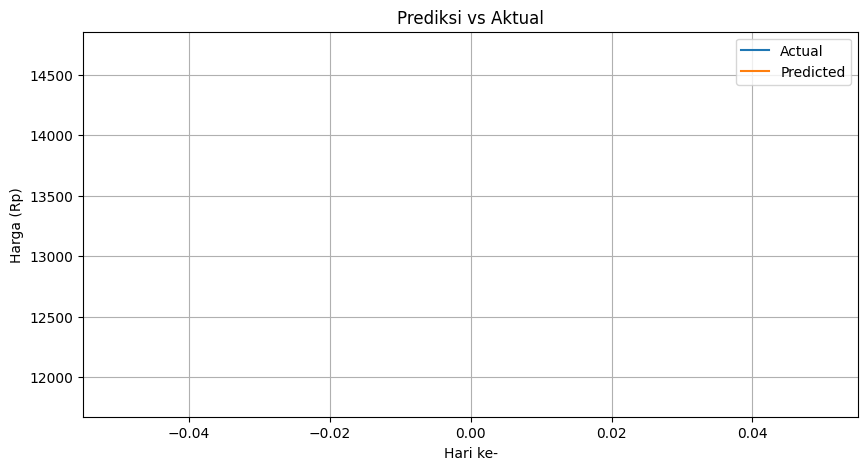

Epoch 0, Train Loss: 0.368402, Val Loss: 0.122821
Epoch 1, Train Loss: 0.134405, Val Loss: 0.059393
Epoch 1, Train Loss: 0.134405, Val Loss: 0.059393
Epoch 2, Train Loss: 0.089597, Val Loss: 0.055764
Epoch 2, Train Loss: 0.089597, Val Loss: 0.055764
Epoch 3, Train Loss: 0.064381, Val Loss: 0.041678
Epoch 3, Train Loss: 0.064381, Val Loss: 0.041678
Epoch 4, Train Loss: 0.049311, Val Loss: 0.037606
Epoch 4, Train Loss: 0.049311, Val Loss: 0.037606
Epoch 5, Train Loss: 0.038355, Val Loss: 0.030941
Epoch 5, Train Loss: 0.038355, Val Loss: 0.030941
Epoch 6, Train Loss: 0.032073, Val Loss: 0.027226
Epoch 6, Train Loss: 0.032073, Val Loss: 0.027226
Epoch 7, Train Loss: 0.028047, Val Loss: 0.022759
Epoch 7, Train Loss: 0.028047, Val Loss: 0.022759
Epoch 8, Train Loss: 0.024630, Val Loss: 0.023374
Epoch 8, Train Loss: 0.024630, Val Loss: 0.023374
Epoch 9, Train Loss: 0.022536, Val Loss: 0.021268
Epoch 9, Train Loss: 0.022536, Val Loss: 0.021268
Epoch 10, Train Loss: 0.020779, Val Loss: 0.018612

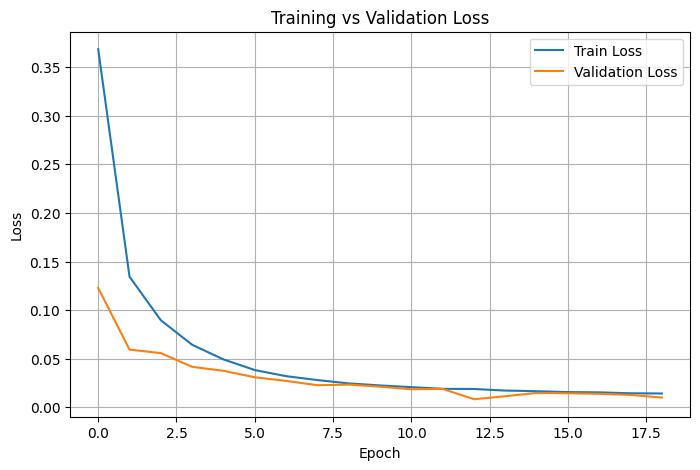

In [24]:
from torch_geometric.loader import DataLoader

# Split: 80% train, 20% val, gunakan split berurutan (bukan random) agar validasi benar-benar out-of-time
split_idx = int(0.8 * len(gnn_dataset))
train_dataset = gnn_dataset[:split_idx]
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ambil batch data dari gnn_dataset untuk prediksi (misal ambil batch pertama)
test_data = gnn_dataset[-1]  # contoh: gunakan data terakhir sebagai test

model.eval()
with torch.no_grad():
    pred = model(test_data.x, test_data.edge_index)

# Kembalikan ke skala asli (per provinsi)
y_true = np.zeros_like(test_data.y.numpy())
y_pred = np.zeros_like(pred.numpy())
for i in range(y_true.shape[0]):
    y_true[i] = scalers[i].inverse_transform(test_data.y.numpy()[i].reshape(1, -1)).reshape(-1)
    y_pred[i] = scalers[i].inverse_transform(pred.numpy()[i].reshape(1, -1)).reshape(-1)

# Hitung metrik akhir (RMSE, MAE, MAPE, R2)
y_true = y_true.flatten()
y_pred = y_pred.flatten()
rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
mae_value = mean_absolute_error(y_true, y_pred)
mape_value = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
r2_value = r2_score(y_true, y_pred)

print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")
print(f"MAPE: {mape_value:.2f}%")
print(f"R2: {r2_value:.2f}")

# Replace the undefined variables with the correct ones
print(f"MAE (Test): {mae_value:.2f}")
print(f"RMSE (Test): {rmse_value:.2f}")

# Visualisasi hasil prediksi vs aktual untuk salah satu provinsi (misal: 'Jawa Barat')
prov_idx = provinsi_to_index['Jawa Barat']
actual_jabar = y_true[prov_idx]       # array shape (30,)
pred_jabar = y_pred[prov_idx]         # array shape (30,)

plt.figure(figsize=(10, 5))
plt.plot(actual_jabar, label='Actual')
plt.plot(pred_jabar, label='Predicted')
plt.title('Prediksi vs Aktual')
plt.xlabel('Hari ke-')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True)
plt.show()
val_dataset = gnn_dataset[split_idx:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = GNNPredictor(in_channels=30,
                     hidden_channels=best_params["hidden_channels"],
                     out_channels=30,
                     dropout=best_params["dropout"])
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_params["lr"],
                              weight_decay=best_params["weight_decay"])
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 6
counter = 0
best_model_state = None

for epoch in range(100):
    model.train()
    total_train_loss = 0
    n_train_batches = 0
    for data in train_loader:
        # Data augmentation: noise lebih kecil
        noise = torch.randn_like(data.x) * 0.005
        x_aug = data.x + noise
        optimizer.zero_grad()
        out = model(x_aug, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        n_train_batches += 1
    avg_train_loss = total_train_loss / n_train_batches
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    n_val_batches = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x, data.edge_index)
            val_loss = criterion(out, data.y)
            total_val_loss += val_loss.item()
            n_val_batches += 1
    avg_val_loss = total_val_loss / n_val_batches
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Visualisasi loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

RMSE: 1308.82
MAE: 596.89
MAPE: 3.22%
R2: 0.69
MAE (Test): 596.89
RMSE (Test): 1308.82


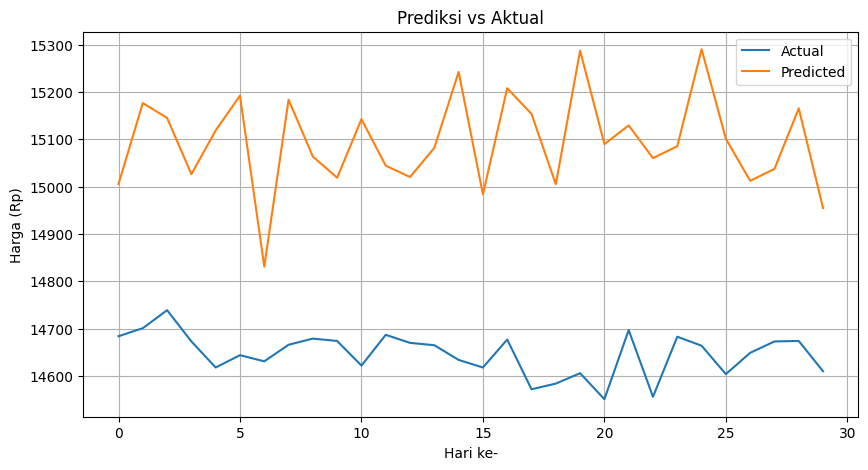

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ambil batch data dari gnn_dataset untuk prediksi (misal ambil batch pertama)
test_data = gnn_dataset[-1]  # contoh: gunakan data terakhir sebagai test

model.eval()
with torch.no_grad():
    pred = model(test_data.x, test_data.edge_index)

# Kembalikan ke skala asli (per provinsi)
y_true = np.zeros_like(test_data.y.numpy())
y_pred = np.zeros_like(pred.numpy())
for i in range(y_true.shape[0]):
    y_true[i] = scalers[i].inverse_transform(test_data.y.numpy()[i].reshape(1, -1)).reshape(-1)
    y_pred[i] = scalers[i].inverse_transform(pred.numpy()[i].reshape(1, -1)).reshape(-1)

# Hitung metrik akhir (RMSE, MAE, MAPE, R2)
y_true = y_true.flatten()
y_pred = y_pred.flatten()
rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
mae_value = mean_absolute_error(y_true, y_pred)
mape_value = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
r2_value = r2_score(y_true, y_pred)

print(f"RMSE: {rmse_value:.2f}")
print(f"MAE: {mae_value:.2f}")
print(f"MAPE: {mape_value:.2f}%")
print(f"R2: {r2_value:.2f}")

# Replace the undefined variables with the correct ones
print(f"MAE (Test): {mae_value:.2f}")
print(f"RMSE (Test): {rmse_value:.2f}")

# Visualisasi hasil prediksi vs aktual untuk salah satu provinsi (misal: 'Jawa Barat')
prov_idx = provinsi_to_index['Jawa Barat']
start_idx = prov_idx * 30
end_idx = (prov_idx + 1) * 30
actual_jabar = y_true[start_idx:end_idx]
pred_jabar = y_pred[start_idx:end_idx]

plt.figure(figsize=(10, 5))
plt.plot(actual_jabar, label='Actual')
plt.plot(pred_jabar, label='Predicted')
plt.title('Prediksi vs Aktual')
plt.xlabel('Hari ke-')
plt.ylabel('Harga (Rp)')
plt.legend()
plt.grid(True)
plt.show()